<a href="https://colab.research.google.com/github/bendavidsteel/trade-democratization/blob/master/temp_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter==2.0.4+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==0.6.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==1.5.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==1.2.0+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 23kB/s 
     |████████████████████████████████| 6.6MB 58.1MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 12.3MB 27.6MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 21.6MB 1.1MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 22.0MB 23.8MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 6.3MB 14.5MB/s 
     |█████████████████████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/projects/trade_democratization/trade/dataset.py" .

In [ ]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_geometric as geo
import tqdm

import dataset

In [ ]:
class TradeDemoYearByYearDataset(geo.data.InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['traddem_raw.pt']

In [ ]:

data_path = os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization')

mapping_path = os.path.join(data_path, "country_mapping.json")
with open(mapping_path, "r") as f:
    country_mapping = json.loads(f.read())

dataset_path = os.path.join(data_path, "dataset")
dataset = TradeDemoYearByYearDataset(dataset_path)

node_dict_path = os.path.join(dataset_path, "processed", "node_dict.pt")
node_dict = torch.load(node_dict_path)

In [ ]:
cty1_code = "RUS"
cty2_code = "DEU"
cty3_code = "ITA"

for cty_idx, code_set in enumerate(country_mapping):
    if cty1_code in code_set:
        cty1_idx = cty_idx
    elif cty2_code in code_set:
        cty2_idx = cty_idx
    elif cty3_code in code_set:
        cty3_idx = cty_idx

In [ ]:
def demo_to_idx(demo):
    if demo >= 0.75:
        return 3
    elif demo >= 0.5:
        return 2
    elif demo >= 0.25:
        return 1
    else:
        return 0

In [57]:
def collect_trade(year_data, cty_trade, cty_colo, trade_idx, cty_idx, year_idx, node_lookup):
    if year_data.edge_index[1, trade_idx] == node_lookup[cty_idx]:
        oth_cty_idx = year_data.edge_index[0, trade_idx]
        oth_cty_demo = year_data.y[oth_cty_idx, 0]
        cty_trade[year_idx, demo_to_idx(oth_cty_demo)] += year_data.edge_attr[trade_idx, 6]
        cty_colo[year_idx, 0] += year_data.edge_attr[trade_idx, 5]


In [58]:
years = []

cty1_gdppop = np.zeros((len(dataset), 2))
cty2_gdppop = np.zeros((len(dataset), 2))
cty3_gdppop = np.zeros((len(dataset), 2))

cty1_gdppop[:, :] = np.nan
cty2_gdppop[:, :] = np.nan
cty3_gdppop[:, :] = np.nan

cty1_demo = np.zeros((len(dataset), 1))
cty2_demo = np.zeros((len(dataset), 1))
cty3_demo = np.zeros((len(dataset), 1))

cty1_demo[:, :] = np.nan
cty2_demo[:, :] = np.nan
cty3_demo[:, :] = np.nan

cty1_trade = np.zeros((len(dataset), 4))
cty2_trade = np.zeros((len(dataset), 4))
cty3_trade = np.zeros((len(dataset), 4))

cty1_colonize = np.zeros((len(dataset), 1))
cty2_colonize = np.zeros((len(dataset), 1))
cty3_colonize = np.zeros((len(dataset), 1))

for year_idx in range(len(dataset)):
    year_data = dataset[year_idx]
    year_metadata = node_dict[year_idx]

    years.append(year_metadata["year"])

    node_lookup = year_metadata["node_mapping"]

    if cty1_idx in node_lookup:
        cty1_gdppop[year_idx, :] = year_data.x[node_lookup[cty1_idx], :2]
        cty1_demo[year_idx, :] = year_data.y[node_lookup[cty1_idx], :]

    if cty2_idx in node_lookup:
        cty2_gdppop[year_idx, :] = year_data.x[node_lookup[cty2_idx], :2]
        cty2_demo[year_idx, :] = year_data.y[node_lookup[cty2_idx], :]

    if cty3_idx in node_lookup:
        cty3_gdppop[year_idx, :] = year_data.x[node_lookup[cty3_idx], :2]
        cty3_demo[year_idx, :] = year_data.y[node_lookup[cty3_idx], :]

    for trade_idx in range(year_data.edge_index.shape[1]):

        if cty1_idx in node_lookup:
            collect_trade(year_data, cty1_trade, cty1_colonize, trade_idx, cty1_idx, year_idx, node_lookup)

        if cty2_idx in node_lookup:
            collect_trade(year_data, cty2_trade, cty2_colonize, trade_idx, cty2_idx, year_idx, node_lookup)

        if cty3_idx in node_lookup:
            collect_trade(year_data, cty3_trade, cty3_colonize, trade_idx, cty3_idx, year_idx, node_lookup)

In [ ]:
cty1_tradealt = np.zeros((len(dataset), 5))
cty2_tradealt = np.zeros((len(dataset), 5))
cty3_tradealt = np.zeros((len(dataset), 5))

cty1_tradealt[:, 0] = np.sum(cty1_trade[:, :], axis=1)
cty1_tradealt[:, 1:] = cty1_trade / cty1_tradealt[:, :1]

cty2_tradealt[:, 0] = np.sum(cty2_trade[:, :], axis=1)
cty2_tradealt[:, 1:] = cty2_trade / cty2_tradealt[:, :1]

cty3_tradealt[:, 0] = np.sum(cty3_trade[:, :], axis=1)
cty3_tradealt[:, 1:] = cty3_trade / cty3_tradealt[:, :1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


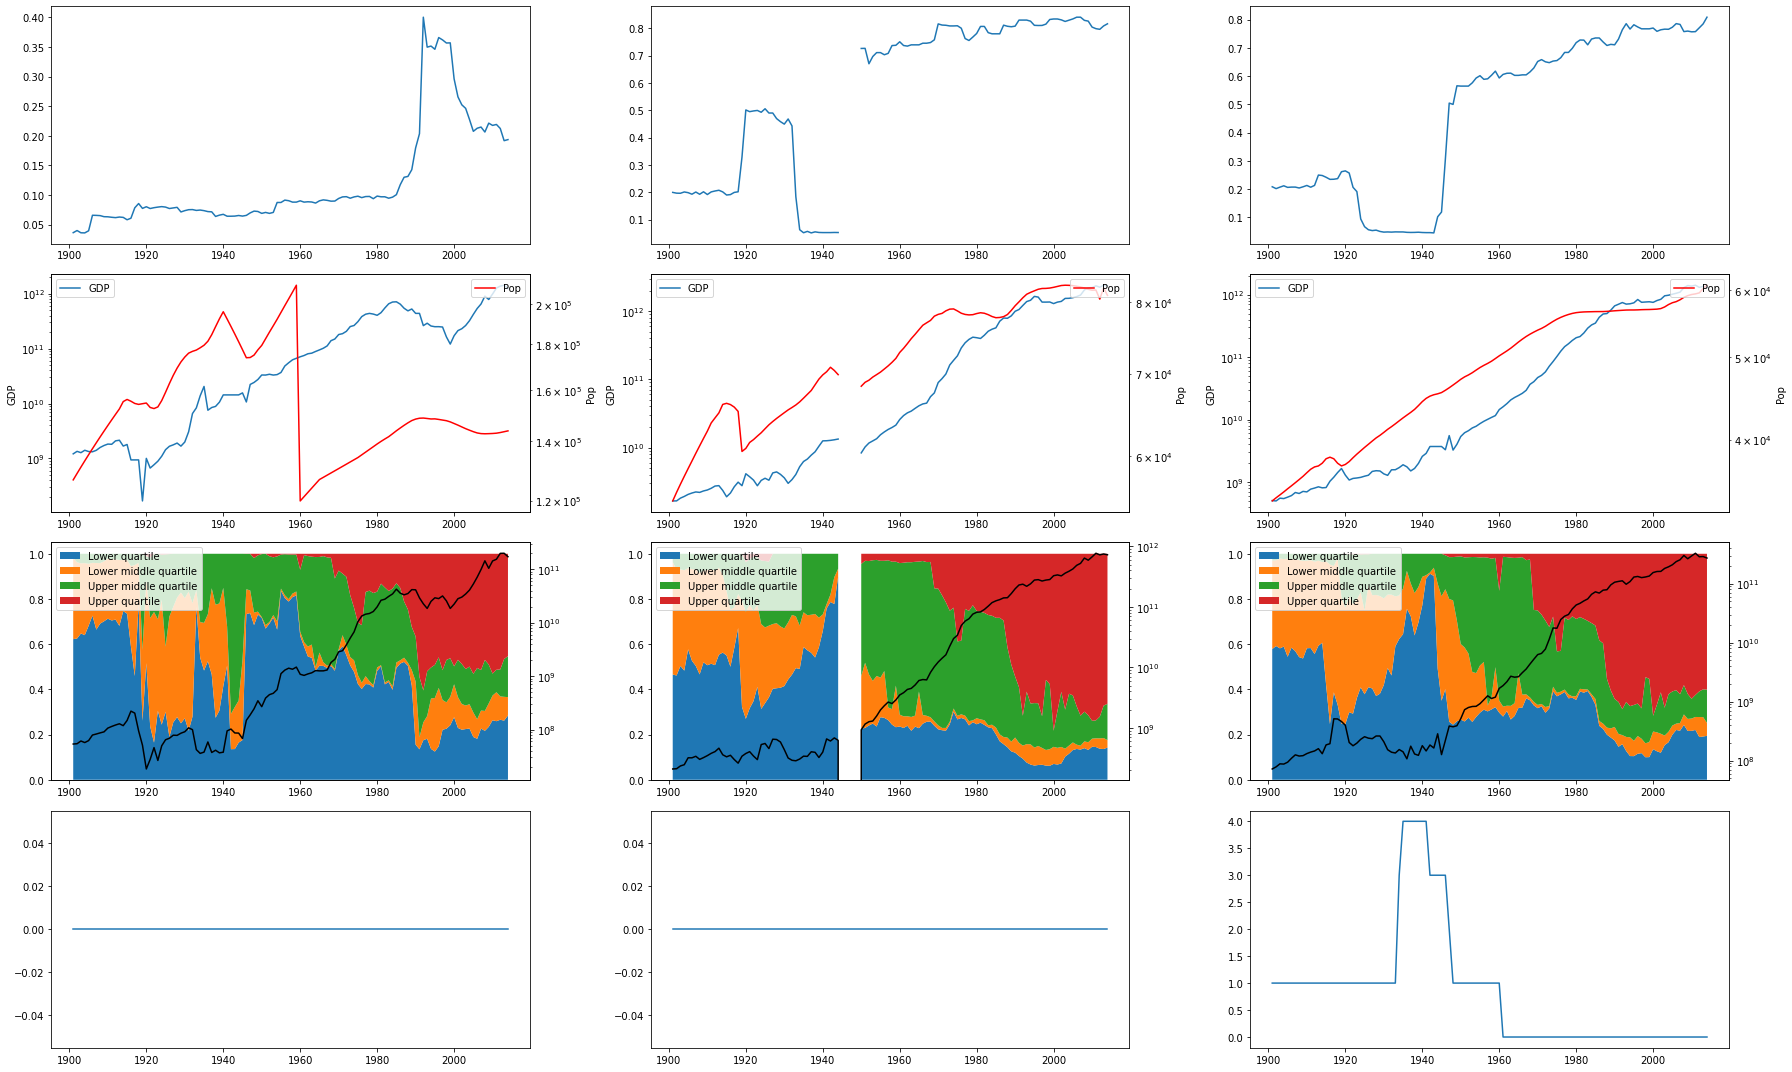

In [59]:
fig, ((ax1_demo, ax2_demo, ax3_demo), (ax1_gdp, ax2_gdp, ax3_gdp), (ax1_trade, ax2_trade, ax3_trade), (ax1_colo, ax2_colo, ax3_colo)) = plt.subplots(nrows=4, ncols=3, figsize=(25, 15))

# plot democracy index

ax1_demo.plot(years, cty1_demo[:, 0])
ax2_demo.plot(years, cty2_demo[:, 0])
ax3_demo.plot(years, cty3_demo[:, 0])

# plot gdp

ax1_gdp.plot(years, cty1_gdppop[:, 0], label="GDP")
ax2_gdp.plot(years, cty2_gdppop[:, 0], label="GDP")
ax3_gdp.plot(years, cty3_gdppop[:, 0], label="GDP")

ax1_gdp.set_ylabel("GDP")
ax2_gdp.set_ylabel("GDP")
ax3_gdp.set_ylabel("GDP")

ax1_gdp.set_yscale("log")
ax2_gdp.set_yscale("log")
ax3_gdp.set_yscale("log")

ax1_gdp.legend(loc='upper left')
ax2_gdp.legend(loc='upper left')
ax3_gdp.legend(loc='upper left')

# plot population

ax1_pop = ax1_gdp.twinx()
ax2_pop = ax2_gdp.twinx()
ax3_pop = ax3_gdp.twinx()

ax1_pop.plot(years, cty1_gdppop[:, 1], 'r', label="Pop")
ax2_pop.plot(years, cty2_gdppop[:, 1], 'r', label="Pop")
ax3_pop.plot(years, cty3_gdppop[:, 1], 'r', label="Pop")

ax1_pop.set_ylabel("Pop")
ax2_pop.set_ylabel("Pop")
ax3_pop.set_ylabel("Pop")

ax1_pop.set_yscale("log")
ax2_pop.set_yscale("log")
ax3_pop.set_yscale("log")

ax1_pop.legend(loc='upper right')
ax2_pop.legend(loc='upper right')
ax3_pop.legend(loc='upper right')

# plot colony data

ax1_colo.plot(years, cty1_colonize)
ax2_colo.plot(years, cty2_colonize)
ax3_colo.plot(years, cty3_colonize)

# plot trade distribution

ax1_trade.stackplot(years, [cty1_tradealt[:, idx] for idx in range(1, cty1_tradealt.shape[1])], labels=["Lower quartile", "Lower middle quartile", "Upper middle quartile", "Upper quartile"])
ax2_trade.stackplot(years, [cty2_tradealt[:, idx] for idx in range(1, cty2_tradealt.shape[1])], labels=["Lower quartile", "Lower middle quartile", "Upper middle quartile", "Upper quartile"])
ax3_trade.stackplot(years, [cty3_tradealt[:, idx] for idx in range(1, cty3_tradealt.shape[1])], labels=["Lower quartile", "Lower middle quartile", "Upper middle quartile", "Upper quartile"])

ax1_trade.legend(loc='upper left')
ax2_trade.legend(loc='upper left')
ax3_trade.legend(loc='upper left')

# plot trade absolute

ax1_tradeabs = ax1_trade.twinx()
ax2_tradeabs = ax2_trade.twinx()
ax3_tradeabs = ax3_trade.twinx()

ax1_tradeabs.plot(years, cty1_tradealt[:, 0], 'k')
ax2_tradeabs.plot(years, cty2_tradealt[:, 0], 'k')
ax3_tradeabs.plot(years, cty3_tradealt[:, 0], 'k')

ax1_tradeabs.set_yscale('log')
ax2_tradeabs.set_yscale('log')
ax3_tradeabs.set_yscale('log')

plt.tight_layout()